In [360]:
#Importing Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image

#custom util functions
from util import *


#Importing Stat Packages
from sklearn.metrics import matthews_corrcoef



In [363]:
#Reading necessary files
data = read_file('Data')

pop = data['population']
dem = data['demographics']
stat = data['status']
loc = data['location']
ser = data['services']

Reading file: Telco_customer_churn_population.xlsx
Reading file: Telco_customer_churn_demographics.xlsx
Reading file: Telco_customer_churn_services.xlsx
Reading file: Telco_customer_churn_status.xlsx
Reading file: Telco_customer_churn_location.xlsx


# Exploratory Data Analysis

In [364]:
data_summary(data)

There are no Missing Values present in Table: population
There are no Missing Values present in Table: demographics
There are no Missing Values present in Table: services
Missing Values Present in columns Index(['Churn Category', 'Churn Reason'], dtype='object')
There are no Missing Values present in Table: location
Total number of rows are 7043 in Table demographics
Unique CusomterIDs are 7043 in Table demographics
Total number of rows are 7043 in Table services
Unique CusomterIDs are 7043 in Table services
Total number of rows are 7043 in Table status
Unique CusomterIDs are 7043 in Table status
Total number of rows are 7043 in Table location
Unique CusomterIDs are 7043 in Table location


- From the initial analysis of the data tables, it Customer ID is the primary key. 
- In order to avoid duplicate rows happening when merging the two tables I have confirmed the number of unique CustomerIDs for each of the table and confirmed every each row is unique. (It Can be confirmed just by looking at the row numbers of each of the table but it would be better for validating)

In [365]:
#Merging all the Tables into one
df = ser.merge(stat, on ='Customer ID')
df = df.merge(dem, on = 'Customer ID')
df = df.merge(loc, on = 'Customer ID')
df = df.merge(pop, on = 'Zip Code')

In [328]:
df.head()

,Customer ID,Count_x,Quarter_x,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,...,Count_y,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,ID,Population
0,8779-QRDMV,1,Q3,No,0,1,None,No,0.00,No,...,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582,21,68701
1,4737-AQCPU,1,Q3,Yes,5,72,None,Yes,42.55,Yes,...,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582,21,68701
2,5043-TRZWM,1,Q3,No,0,1,None,Yes,7.11,No,...,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582,21,68701
3,8165-CBKXO,1,Q3,Yes,4,66,None,No,0.00,No,...,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582,21,68701
4,9979-RGMZT,1,Q3,No,0,7,Offer E,Yes,36.49,No,...,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582,21,68701


Unecessary variables will be dropped
- Count
- ID
- Quarter
- Customer Stauts, Churn Score, Churn Value, Satisfaction Score (Defeats Purpose of Churn Prediction)
<br>
<br>
*Note: Satistisfaction Score doens't necessarily need to be removed but receiving customer's satisfaction score is not practically possible
<br>
<br>
- Also this score may only be obtained from small portion of the population which may incur bias 
- This dataset does include score for all the customers, but lets assume this is not always the case

In [366]:
#Dropping Unesseary Columns
df.drop(columns = ['Count_x', 'Quarter_x', 'Count_y', 'ID','Quarter_y', 'Churn Value', 'Customer Status', 'Churn Value', 'Satisfaction Score', 'Churn Score'], inplace = True)

In [367]:
df['Churn Label'] = df['Churn Label'].map({'Yes': 1, 'No': 0})

In [9]:
#Summary Statistics
df.describe()

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label,CLTV,Age,Number of Dependents,Zip Code,Latitude,Longitude,Population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,0.265370,4400.295755,46.509726,0.468692,93486.070567,36.197455,-119.756684,22139.603294
std,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,0.441561,1183.057152,16.750352,0.962802,1856.767505,2.468929,2.154425,21152.392837
min,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,0.000000,2003.000000,19.000000,0.000000,90001.000000,32.555828,-124.301372,11.000000
25%,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,0.000000,3469.000000,32.000000,0.000000,92101.000000,33.990646,-121.788090,2344.000000
50%,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,0.000000,4527.000000,46.000000,0.000000,93518.000000,36.205465,-119.595293,17554.000000
75%,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,1.000000,5380.500000,60.000000,0.000000,95329.000000,38.161321,-117.969795,36125.000000
max,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,1.000000,6500.000000,80.000000,9.000000,96150.000000,41.962127,-114.192901,105285.000000


- We can initially confirm that all the dataset values are acceptable (There aren't any values that are abnormal - in terms of quality).
- Also the Null values that are captured from the helper function can be thought as that the customers that did not churn indeed have no reasoning for churn

## EDA

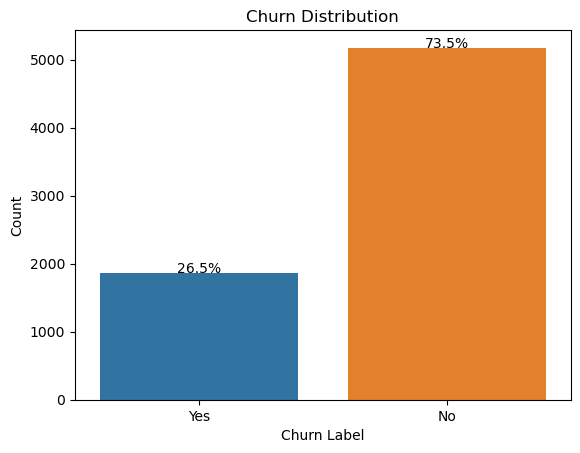

In [345]:
# Plotting the bar chart with reversed order
ax = sns.countplot(x='Churn Label', data=df, order=df['Churn Label'].value_counts().index[::-1])

# Calculate percentages
total = len(df)
percentages = [(count/total) * 100 for count in df['Churn Label'].value_counts().sort_index(ascending=False)]

# Adding percentage labels
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{percentages[i]:.1f}%',
            ha='center')

# Adding labels and title
plt.xlabel('Churn Label')
plt.ylabel('Count')
plt.title('Churn Distribution')

# Display the plot
plt.show()


Churn label is indeed imbalanced where the ratio is about 7:3. This is not a severe imbalance unlike anomaly/fraud detection where it is usuaully 9:1 or worse. The current ratio of imbalance may not require additional control (Oversampling or Undersampling).

In [347]:
#Preparing data for Churn Reason
reason_data = (stat[['Churn Category', 'Churn Reason']].value_counts(dropna =True).sort_index() / len(stat) * 100)
churn_cat = (stat['Churn Category'].value_counts(dropna =True).sort_index() / len(stat) * 100)

In [352]:
# Assuming you have the output stored in a variable called 'value_counts'
value_counts = pd.Series(churn_cat.values, 
                         index= churn_cat.index)

# Create a pie plot using Plotly
fig = go.Figure(data=[go.Pie(labels=value_counts.index, values=value_counts)])

# Set layout options
fig.update_layout(
    title='Churn Reasons - Overview',
    height=600,
    width=800,
)

# Display the plot
fig.show()


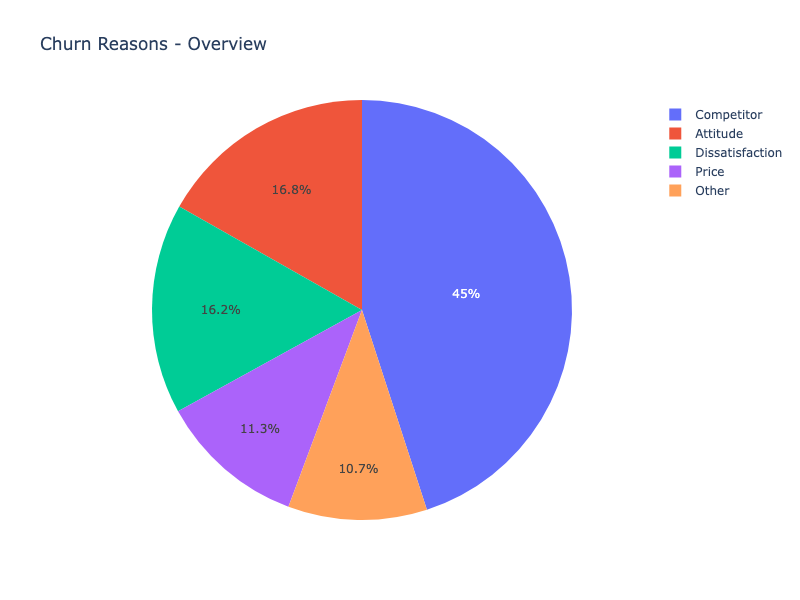

In [390]:
Image(filename='ChurnOver.png') 


In [354]:
# Assuming you have the output stored in a variable called 'value_counts'
value_counts = pd.Series(reason_data.values, 
                         index= reason_data.index)

# Create a pie plot using Plotly
fig = go.Figure(data=[go.Pie(labels=value_counts.index, values=value_counts)])

# Set layout options
fig.update_layout(
    title='Churn Reasons - Detailed View',
    height=600,
    width=1000,
)

# Display the plot
fig.show()


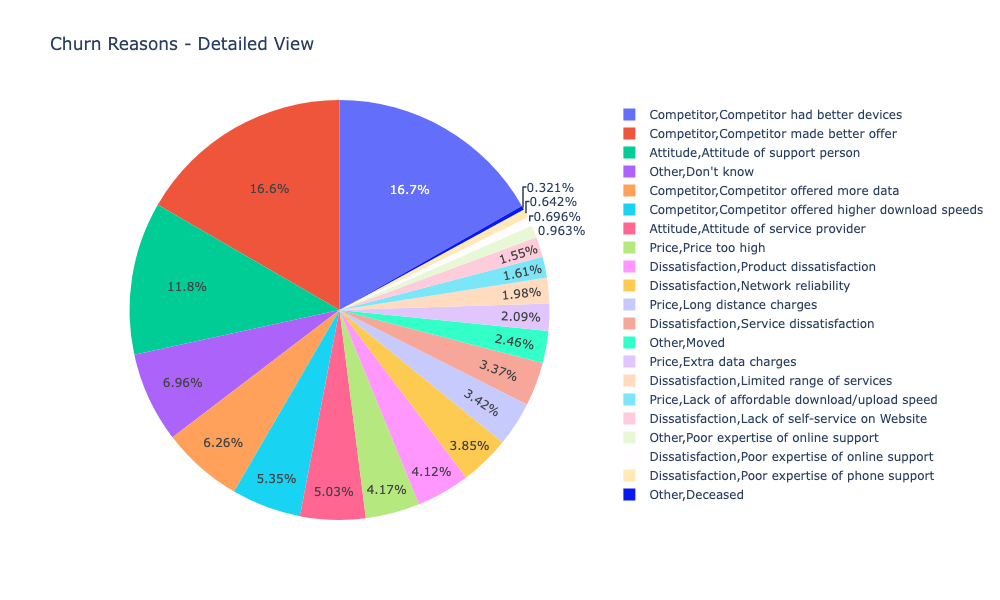

In [392]:
Image(filename='ChurnDetail.png') 


- Churn Decision is highly dependent on the Competitor

In terms of the competitor behavior, it can be seen that the either the better sevice or price attracted customers, and therefore it might be approprirate for the analysis to focus more on the service and pricing aspect instead of location specific
<br>
- Atitude also shows high impact on the churn 


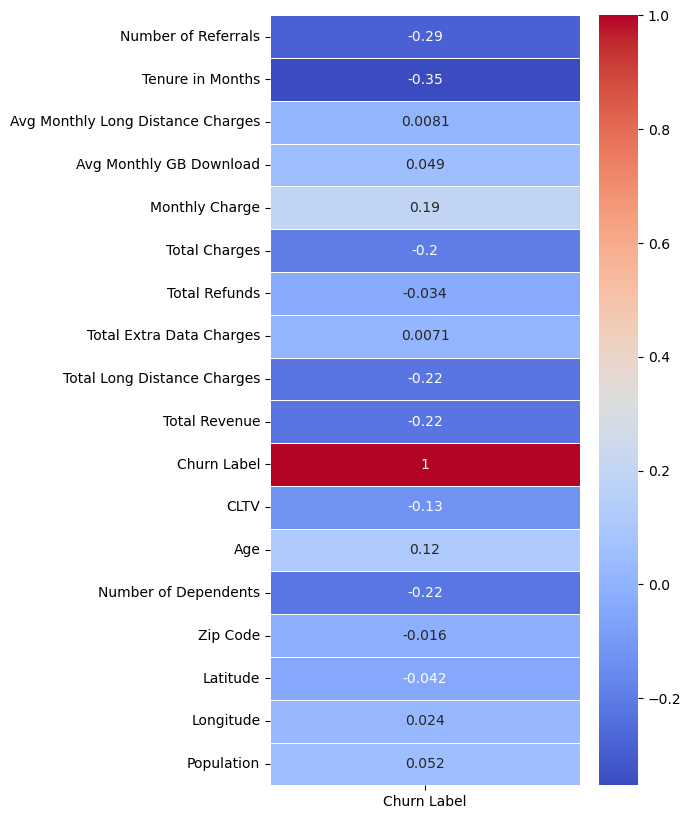

In [10]:
# Compute correlation
corr = df.corr()

# Get correlation with 'Churn Label' column
churn_corr = corr['Churn Label']

# Plot
plt.figure(figsize=(5,10))
sns.heatmap(churn_corr.to_frame(), annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.show()


We can see that for continuous random variables, there aren'y any huge correlation with the churn label.

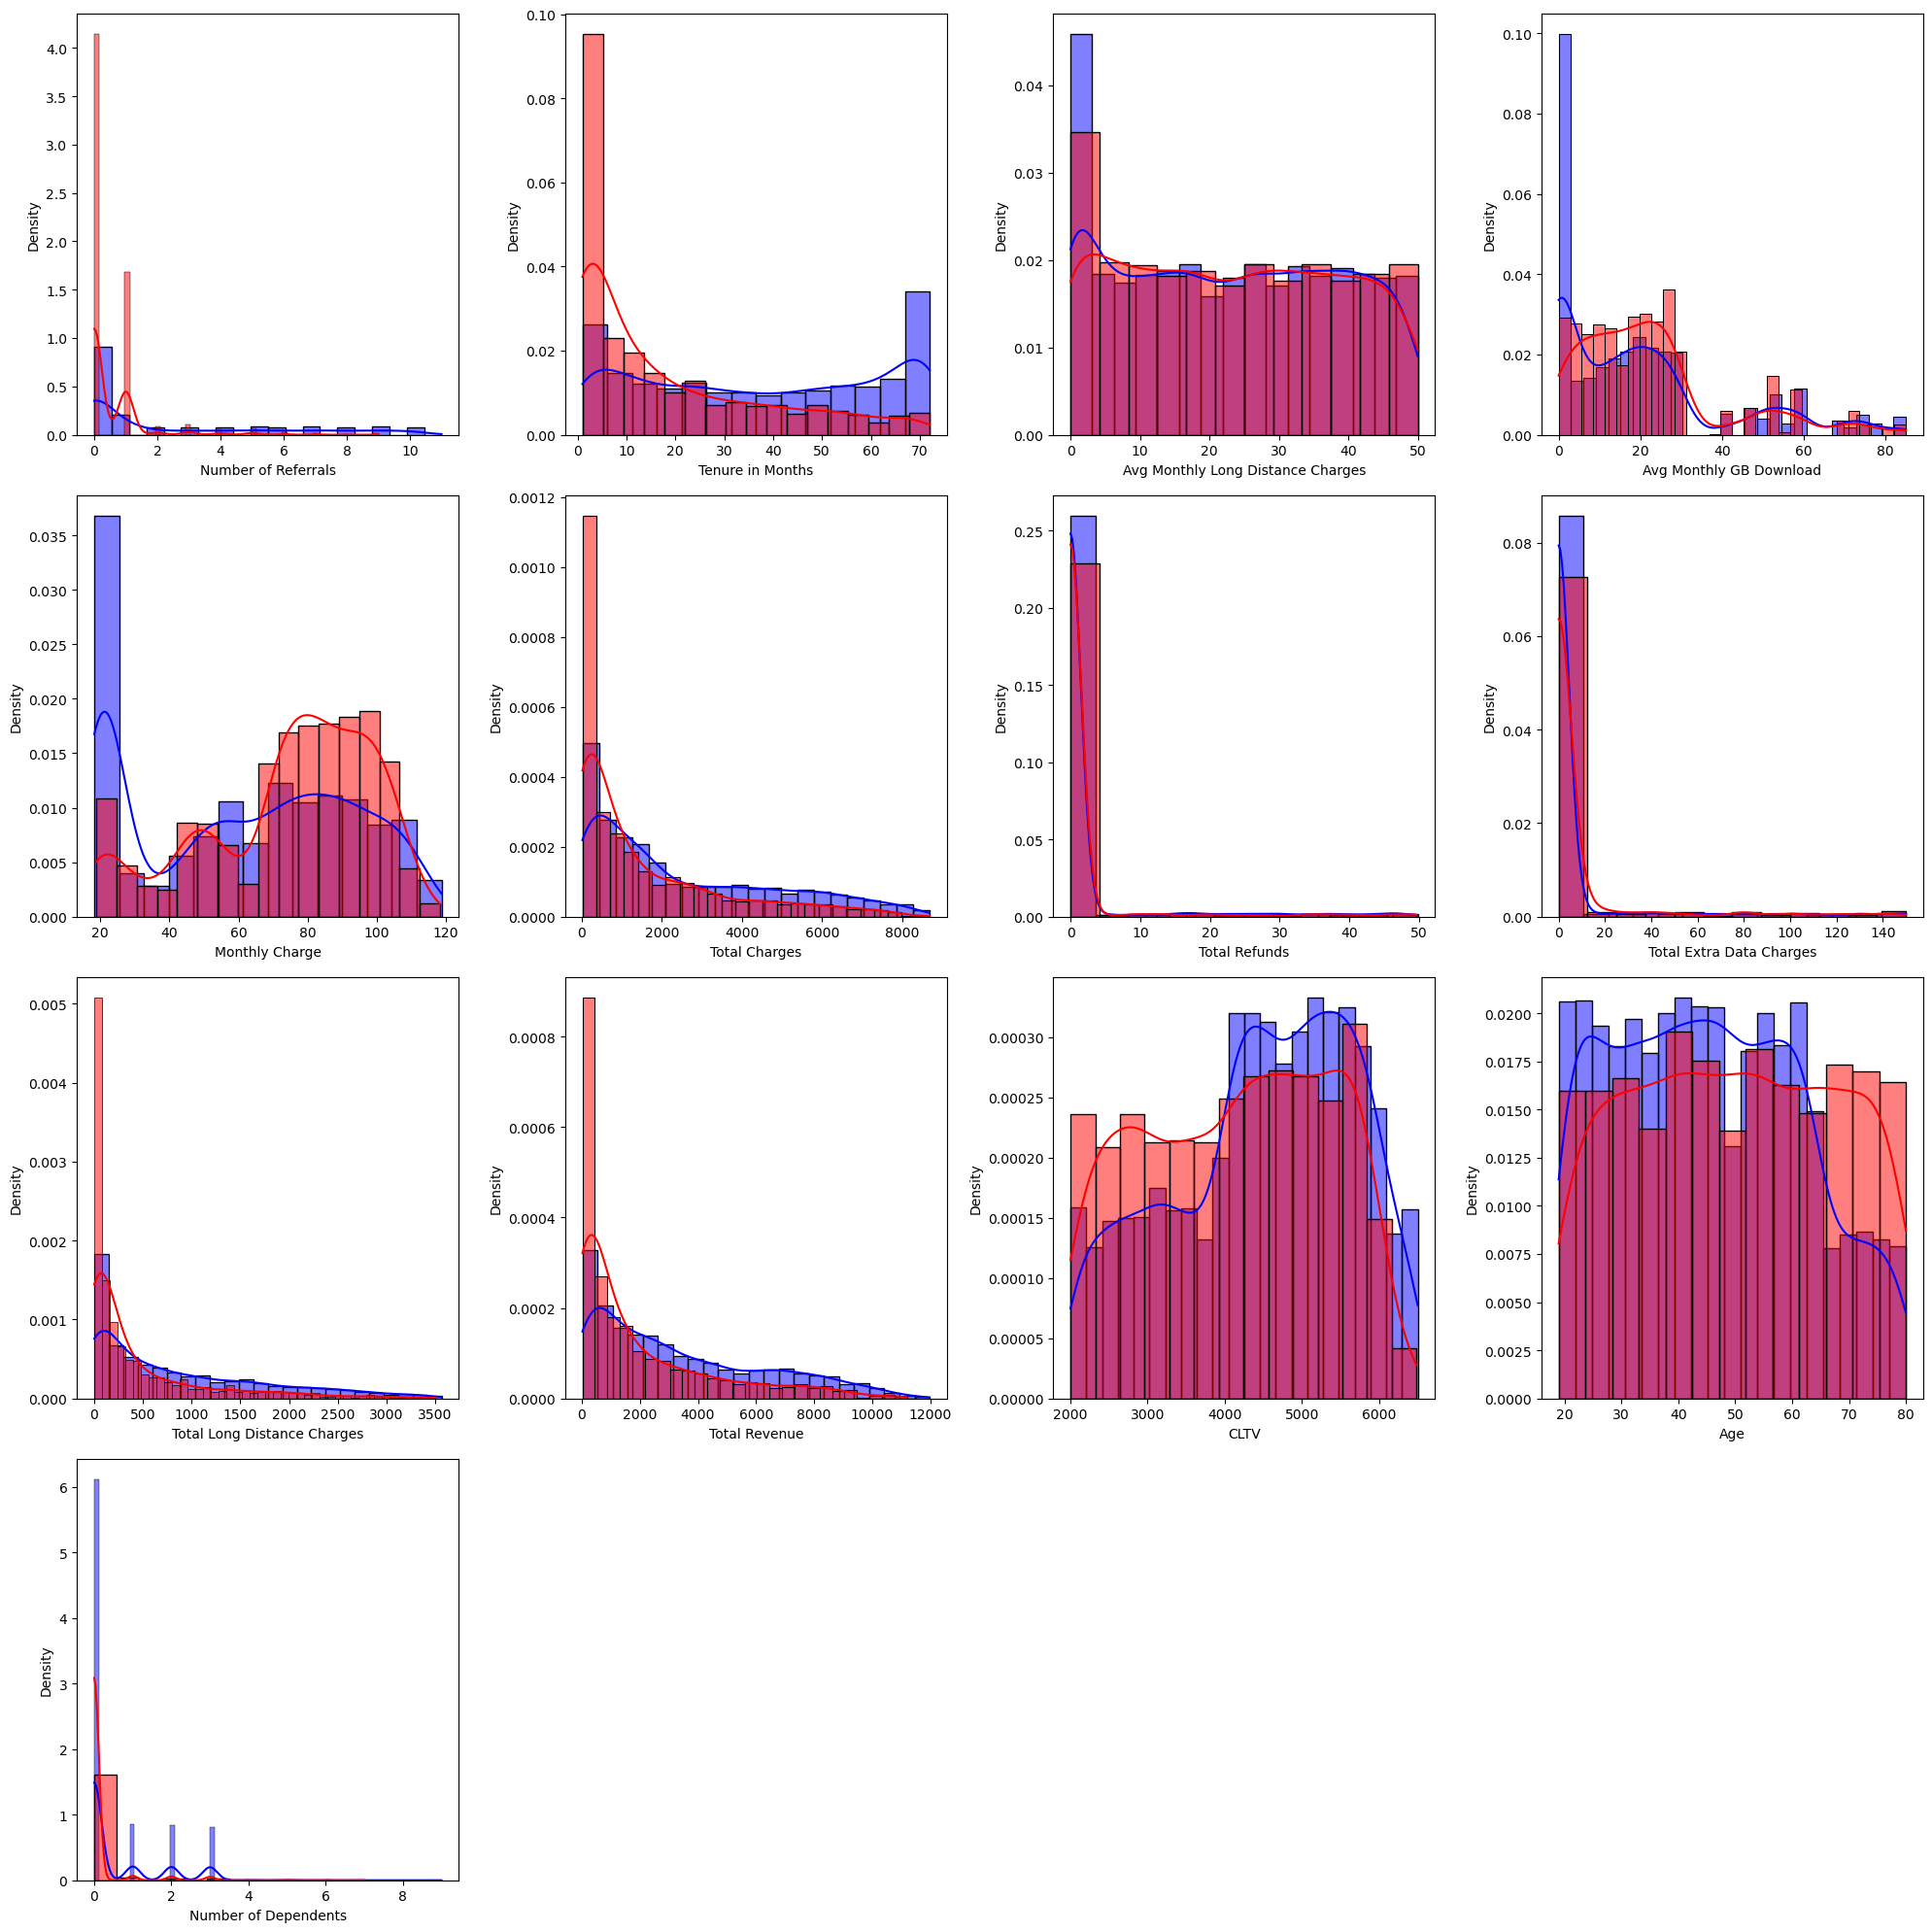

In [13]:
dist_cols = ['Number of Referrals', 'Tenure in Months',
            'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
            'Monthly Charge', 'Total Charges', 'Total Refunds',
            'Total Extra Data Charges', 'Total Long Distance Charges',
            'Total Revenue', 'CLTV', 'Age',
            'Number of Dependents']

nrow = len(dist_cols) // 4 + (len(dist_cols) % 4 > 0)
ncol = 4

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 20))

# iterate over the length of dist_cols, not nrow*ncol
for i in range(len(dist_cols)): 
    ax = plt.subplot(nrow, ncol, i+1)
    col_name = dist_cols[i]
    for label, color in zip([0, 1], ['blue', 'red']):
        #Using the stat = 'density' will scale the data so that churn and not churn histograms are compared with same scale
        sns.histplot(data = df[df['Churn Label'] == label], x = col_name, ax = ax, color = color, kde=True, stat='density')

# Remove the empty subplots
if len(dist_cols) < nrow*ncol:
    for i in range(len(dist_cols), nrow*ncol):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


From the distribution graph above, its can be seen that the monthly charge amount and the Tenure in month as well as age seems to have some impact on the churn since they are the ones that have the most visual difference based on the histogram graph. (we will not consider Churn Score because our goal is to predict Churn customer but the churn score itself is indeed is a strong indicator of Churn, Let's assume that we are not given such a big helper on our analysis)

# Binary Variables Correlation Analysis

In [368]:
from collections import defaultdict

data_types = defaultdict(list)

#Split data into different data types
for col in df.columns:
    num_class = df[col].nunique()
    if num_class== 2:
        data_types['Binary'].append(col)
    elif num_class > 2 and num_class <= 6:
        data_types['Categorical'].append(col)
    elif num_class != 1:
        data_types['Continuous'].append(col)


In [79]:
#Preprocessing Binary Features
binary_data = df[data_types['Binary']]
binary_data = binary_data.select_dtypes(include= ['object'])

#Exclude Gender for now
cols = [i for i in binary_data.columns if i != 'Gender']

# Encoding Strings into binary 
binary_data[cols] = binary_data[cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}), axis = 1)
binary_data['Gender'] = binary_data['Gender'].map({'Male' : 1, 'Female': 0})

binary_data['Churn Label'] = df['Churn Label']


In [17]:
#One Hot Encoded variables
binary_data.head()

,Referred a Friend,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Paperless Billing,Gender,Under 30,Senior Citizen,Married,Dependents,Churn Label
0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1
1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0
2,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,1,0,1,1,0,1,1,1,1,1,1,0,0,1,1,0
4,0,1,0,1,0,1,0,0,1,1,1,1,1,0,1,0,0,0,0


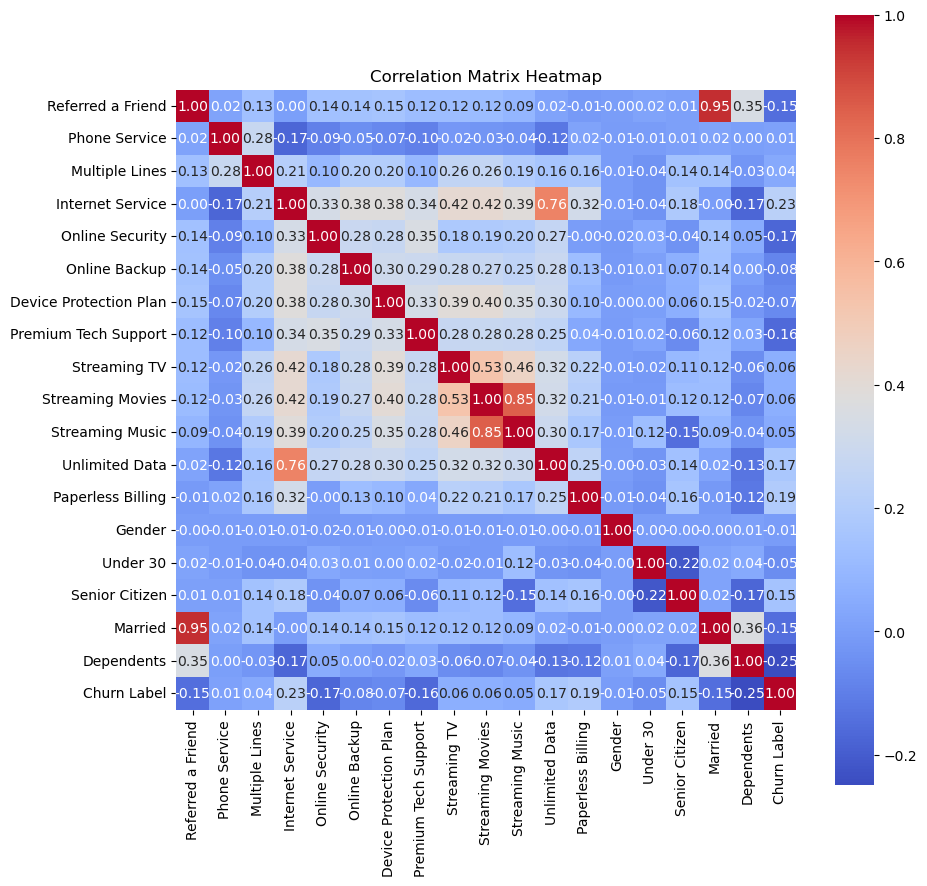

In [369]:
#Please refer to the utils function code
#Correlation measure was done using Matthew's correlation measure (Specific For Comparing Binary variables)
corr_matrix = plot_binary_corr(binary_data)

From the binary variable analysis, 
- marries statues and the referring friend showed high correation
- Unlimited data and Internet service
- Streamling Music and Streaming Movie

Churn label seems to have low correlation between all the features

# Statistical Analysis and Feature Engineering

In [370]:
#Initializing the dataframe for each data types
cont = df[data_types['Continuous']].drop(columns = ['City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Population', 'Customer ID', 'Churn Reason'])
cont['Churn Label'] = df['Churn Label']

category = df[data_types['Categorical']]
category = category.drop(columns = ['Churn Category'])


### Continuous Variable Analysis -  Distribution Dissimilarity Measure
- Distribution of the continuous data showed different shapes when we compared Churn vs Not-Churn
- Measuring the Dissimilarity measure of the distribution may able to identify what are some of the features that can influence churn rate
- We can see that the most of our data is skewed, which will not be efficient when we are performing dissimilarity measures (Divergence) therefore it is appropriate to transform our data

Statistical Tests:

1. Kolmogorov-Smirnov Test (KS-test)
- This is a nonparametric test that compares the cumulative distribution function of two probability distributions to test the null hypothesis that they are drawn from the same distribution.
2. Kullback-Leibler Divergence (KL-divergence)
- This is a measure of how one probability distribution diverges from a second expected probability distribution.
3. Earth Mover's Distance (EMD) 
- is a measure of dissimilarity between two probability distributions. It is a way to quantify the minimum amount of work required to transform one distribution into another, where the distributions are represented as histograms.

In [371]:
# Computing the distribution dissimilarity measure (Please refer to the utils function on how this is computed)
dissimilarity_measures = calculate_dissimilarity(cont, cont.columns[:-1], 'Churn Label', transformation='yeo-johnson')
dissimilarity_measures

,ks,js,emd
Number of Referrals,0.327620,0.527652,0.535232
Tenure in Months,0.357360,0.318391,0.842064
Avg Monthly Long Distance Charges,0.022232,0.098083,0.021785
Avg Monthly GB Download,0.212636,0.227327,0.326237
Monthly Charge,0.248599,0.296688,0.457148
Total Charges,0.222616,0.237769,0.534258
Total Refunds,0.023836,0.039325,0.089583
Total Extra Data Charges,0.033365,0.037586,0.109449
Total Long Distance Charges,0.274136,0.250931,0.519440
Total Revenue,0.267449,0.233455,0.611458


The result shows that the following features are dissimilar (The range values is 0-1)
- Tenure in Months
- Monthly Charge
- Total Charges
- Total Long Distance Charges
- Total Revenue
- Number of Dependents

### Discrete Variable Analysis - Hypothesis Testing

For discrete variables, (mostly binary) distribution dissimilarity measure cannot be used and therefore requires hypothesis testing designed for these variables.
- Will be tested whether the features are dependent on Churn label or not 

Statistical Test:
1. Chi-squared Test
-  is a statistical test that determines whether there is a significant association between two categorical variables
2. Cramer V Test
- Cramer's V is a measure of association or correlation between categorical variables. It is an extension of the chi-squared test statistic that takes into account the dimensions of the contingency table (quantifies the strength of the relationship)

In [372]:
#Getting the Columns
bin_cols = [i for i in binary_data.columns  if i != 'Churn Label']

# replace 'df' with your dataframe's name and 'Churn Label' with your target column's name
categorical_associations = calculate_categorical_association(binary_data, bin_cols, 'Churn Label')

categorical_associations

,chi2_pvalue,cramer_v
Referred a Friend,8.723768e-36,0.148332
Phone Service,3.387825e-01,0.000000
Multiple Lines,8.433795e-04,0.037952
Internet Service,2.920300e-81,0.227204
Online Security,1.232098e-46,0.170467
Online Backup,6.214093e-12,0.081051
Device Protection Plan,3.315693e-08,0.064738
Premium Tech Support,2.923567e-43,0.163898
Streaming TV,1.302484e-07,0.061762
Streaming Movies,2.997474e-07,0.059882


In [373]:
#One hot encoding of categorical variables
ccols = ['Offer', 'Internet Type', 'Contract', 'Payment Method']
ohe_category = pd.get_dummies(category[ccols])
ohe_category['Churn Label'] = df['Churn Label']

In [374]:
#performing the hypothesis testing on the data
categorical_association2 = calculate_categorical_association(ohe_category, ohe_category.columns[:-1], 'Churn Label')
categorical_association2

,chi2_pvalue,cramer_v
Offer_None,2.399339e-01,0.007354
Offer_Offer A,3.787715e-26,0.125484
Offer_Offer B,7.749161e-23,0.116624
Offer_Offer C,9.364067e-02,0.016034
Offer_Offer D,9.424925e-01,0.000000
Offer_Offer E,3.262592e-72,0.213826
Internet Type_Cable,5.716896e-01,0.000000
Internet Type_DSL,7.645850e-17,0.098626
Internet Type_Fiber Optic,1.693705e-121,0.279064
Internet Type_None,2.920300e-81,0.227204


It is seen that most of the features from chi-sqaured test were siginificant (rejection of the hypothesis) and therefore cramer-v was used to make deicison (since it measures the magnitude)

- Contract_Two Year	
- Contract_Month-to-Month	
- Internet Type_Fiber Optic	
- Dependents

However, the values are relatively low (Since the range is from 0 - 1)

In [385]:
catfeat = list(categorical_association2.sort_values(by = 'cramer_v', ascending= False)['cramer_v'][:10].index)
confeat = list(dissimilarity_measures.sort_values(by = 'emd', ascending=False)['emd'][:10].index)
selected_features = list(set(catfeat + confeat))

print(f'Top 20 Features with highest scores are: \n{selected_features}')

Top 20 Features with highest scores are: 
['Payment Method_Bank Withdrawal', 'Avg Monthly GB Download', 'CLTV', 'Contract_One Year', 'Number of Referrals', 'Total Long Distance Charges', 'Total Revenue', 'Payment Method_Credit Card', 'Offer_Offer B', 'Internet Type_None', 'Total Charges', 'Offer_Offer E', 'Contract_Two Year', 'Tenure in Months', 'Contract_Month-to-Month', 'Internet Type_Fiber Optic', 'Age', 'Monthly Charge', 'Offer_Offer A', 'Number of Dependents']


In [377]:
def check_correlation(continuous, binary):
    from scipy import stats

    # Suppose 'binary_var' is your binary variable and 'numerical_var' is your numerical variable.
    binary_var = binary_data[binary]
    numerical_var = df[continuous]

    # Using Scipy's pointbiserialr function (Continuous vs Binary correlation measure)
    correlation, p_value = stats.pointbiserialr(binary_var, numerical_var)

    print('Correlation:', correlation)
    print('P-value:', p_value)


#Checking the Correlation fo the Redundant Variables (Continuous vs Binary)
check_correlation('Number of Referrals', 'Referred a Friend')
check_correlation('Age', 'Under 30')
check_correlation('Age', 'Senior Citizen')
check_correlation('Number of Dependents', 'Dependents')

Correlation: 0.7082914387630278
P-value: 0.0
Correlation: -0.6726507775313311
P-value: 0.0
Correlation: 0.6815071891170049
P-value: 0.0
Correlation: 0.8882337266474611
P-value: 0.0


Because some of the features (continuous and binary) share similarity, testing their correlation and remove them

In [378]:
#Keeping more granular information and removing the unecessary binary variables
binary = binary_data.drop(columns = ['Referred a Friend','Under 30', 'Senior Citizen', 'Dependents'])
binary.drop(columns = ['Churn Label'], inplace = True)

#Drop Label before merging
ohe_category = ohe_category.drop(columns=['Churn Label'])

#Merging CLeaned data
dr_df = cont.merge(binary, left_index=True, right_index=True)
dr_df = dr_df.merge(pd.get_dummies(ohe_category[ohe_category.columns]), left_index = True, right_index = True)

In [379]:
dr_df.head()

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,...,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_None,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
0,-0.86902,-1.650122,-1.771361,-0.342508,-0.821208,-1.729141,-0.283804,2.945379,-1.783396,-1.739257,...,0,1,0,0,1,0,0,1,0,0
1,1.35148,1.343103,1.163362,0.253760,0.259293,1.150089,-0.283804,-0.339530,1.657219,1.394521,...,0,1,0,0,0,0,1,0,1,0
2,-0.86902,-1.650122,-0.954201,0.582639,0.371758,-1.518909,-0.283804,-0.339530,-1.416190,-1.640801,...,0,0,1,0,1,0,0,1,0,0
3,1.25140,1.202609,-1.771361,0.545672,-0.246136,0.849561,-0.283804,-0.339530,-1.783396,0.561678,...,1,0,0,0,0,0,1,0,1,0
4,-0.86902,-1.005174,0.870537,1.073720,0.968895,-0.514447,-0.283804,-0.339530,-0.180012,-0.555414,...,0,0,1,0,0,1,0,0,1,0


<AxesSubplot:>

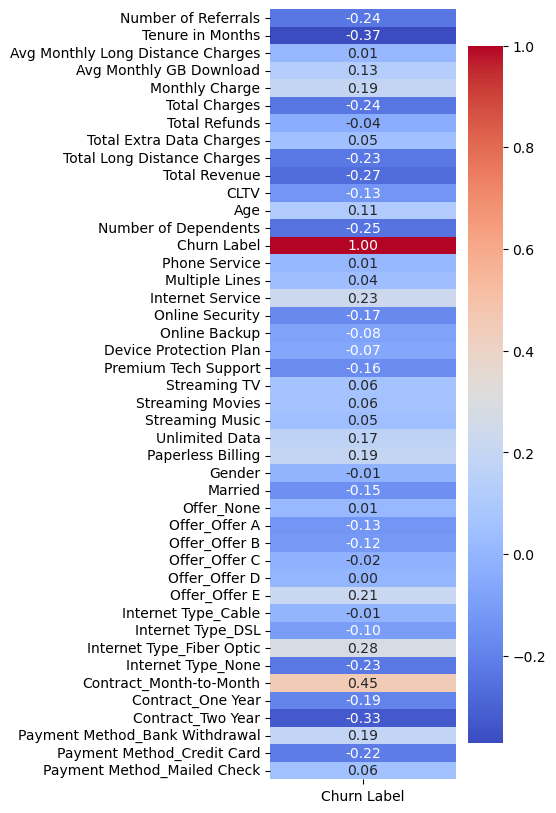

In [380]:
#Visualizing the Correlation of all the variables for Churn Label
plt.figure(figsize = (3, 10))
co = dr_df.corr()
sns.heatmap(co['Churn Label'].to_frame(), cmap='coolwarm',  fmt=".2f", annot = True)

<AxesSubplot:>

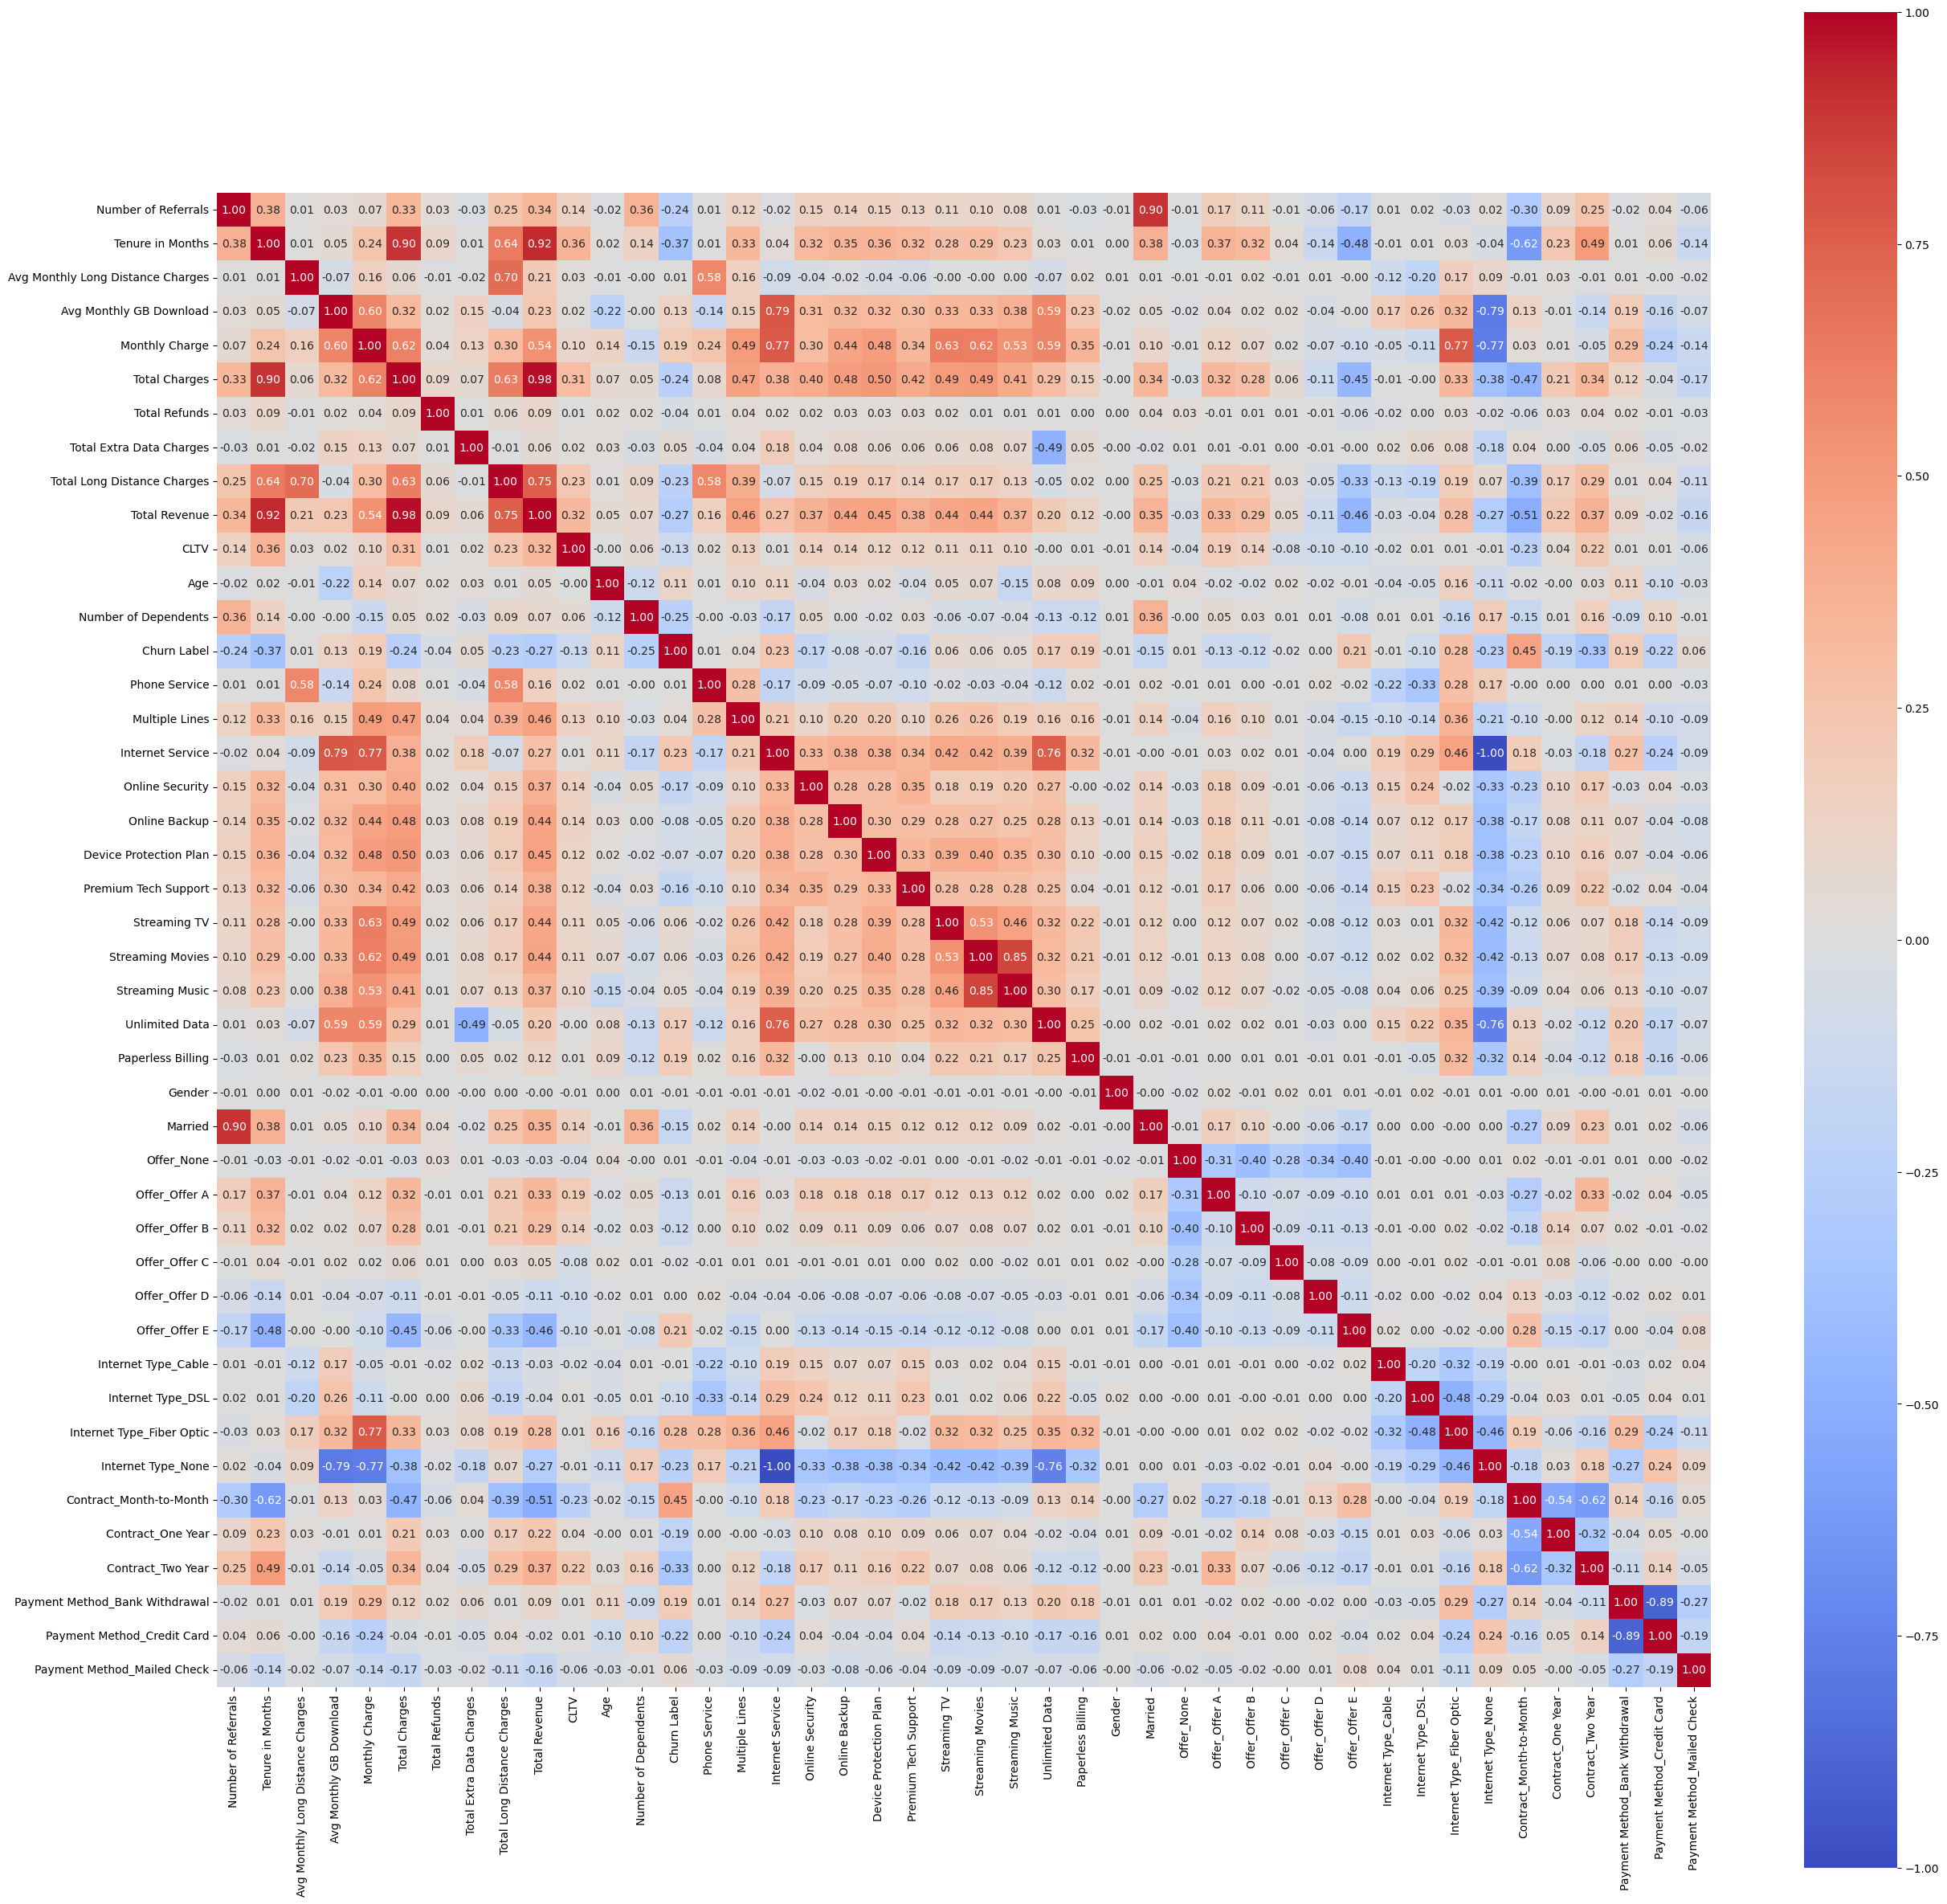

In [30]:
#Visualizing the Entire Correlation
plt.figure(figsize = (30, 30))
sns.heatmap(co,cmap='coolwarm',  fmt=".2f", square=True , annot = True)

# Conclusion
- Statistical meausres identified some of the important variables that shows distinct characteristics for Churn and Not-Churn customers.
- This measuremnet can be used to perform feature selection as well as generating more informative features. (May Require more domain knowledge on a specific measurement)
- It would add more explanability when we were to use tree-based models. 